# Simple high thoughput nontargeted direct-infusion mass spectrometry processing using dimspy.

This example focuses on the generation of low resolution spectra, resultiing in a matrix containing binned nominal mass spectrum - ideal for further statistical analysis/machine learning.

Much of this protocol has been adapted from **High-throughput, nontargeted metabolite fingerprinting using nominal mass flow injection
electrospray mass spectrometry** by Beckmann et al.

To begin, we need to load in a couple of libraries:

In [1]:
# The dimspy package.
import dimspy
# Python's standard operating system interface.
import os

Whilst it isn't required for us to load in the ```os``` library, it should make dealing with input/output a lot simpler.

Now we can begin setting our basic variables: 

*Note: this is by no means a 'one size fits all' approach, getting the best quality output takes plenty of trial and error*

In [2]:
# The directory where our mzML files are located.
data_dir = "/home/keo7/Data/dimspy-example/"

# The total number of threads to use for processing, 1 is the default.
n_jobs = 16

# The polarity you're interested in analysing.
polarity = "positive"

# The parameters fed in to the mzML -> raw values converter.
processing_parameters = {
    "MS1 Precision" : 5e-6, # Precision of MS1 runs.
    "MSn Precision" : 5e-6, # Precision of MSn runs.
    "Measured Precision" : 5e-6, # Precision of loaded spectrum.
    "Scan Range" : "apex", # "apex" identifies and limits the read scans to "likely sample". 
    "Peak Type" : "peaks" # whether you want the raw peaks, or make use of centroid-aided peak detection.
}

Just for peace of mind we can make use of the ```listdr``` method within the ```os``` library to ensure that our folder configurations are set-up correctly:

In [4]:
os.listdir(data_dir)

['dirty1.mzML',
 'dirty2.mzML',
 'C030.mzML',
 'C029.mzML',
 'MM03.mzML',
 'ctrl02.mzML',
 'MM02.mzML',
 'MM01.mzML',
 'MM04.mzML',
 'C032.mzML',
 'C027.mzML',
 'ctrl01.mzML']

Before we process the files, we need somewhere to store our loaded spectrum. Whilst a standard python list (```[]```) will suffice for storage alone, we also want to make use of inbuilt methods provided by ```dimspy```. To do this, instanciate a new SpectrumList object. 

In [5]:
spectrum_list = dimspy.SpectrumList()

Now we're ready to start looping through our files and processing the ```.mzML``` files. Whilst it's not entirely necessary, it's highly advised to also provide injection order information as to make full use of the processing package. 

In [8]:
# Creating an injection_order dictonary, containing the file name and injection order.
injection_order = {
    "C029" : 1,
    "MM02" : 2,
    "C030" : 3,
    "MM03" : 4,
    "ctrl02" : 5,
    "ctrl01": 6,
    "MM04" : 7,
    "C027" : 8,
    "C032" : 9,
    "MM01" : 10,
    "dirty1" : 11,
    "dirty2" : 12
}

# Looping through the files found in the given data directory.
for file in os.listdir(data_dir):
    # Creating a new spectrum object using the parameters we set earlier.
    spectrum = dimspy.Spectrum(os.path.join(data_dir, file),
                              polarity=polarity,
                              parameters=processing_parameters,
                              # Splitting the filename by extension (".").
                              injection_order=injection_order[file.split(".")[0]])
    # Adding the spectrum to our SpectrumList object.
    spectrum_list.append(spectrum)

Depending on how much data you're processing, this may take awhile - so pop the kettle on and have a well earned cuppa as you wait for it to process.

Once completed, check the ```SpectrumList``` object to ensure that the Spectrum has been loaded in correctly. We can do this by using the ```to_list``` method, which outputs the object as a standard python list:

In [9]:
spectrum_list.to_list()

A common problem with mass spectrometry-based experimentation are sample outliers. Due to technical reasons, some data may be considered as being extreme - which may potentially bias any further analysis resulting in unreliable results. Although complex mass/intensity algorithms exist, a quick way of analysing the data is to study each spectrums total ion count.

This is fairly simple to achieve, by looping through the Spectrum objects contained our created SpectrumList object:

In [11]:
print "Index\tSpectrum ID\tTIC"
for index, spectrum in enumerate(spectrum_list.to_list()):
    print index, spectrum.id, "\t", sum(spectrum.intensities)

Index	Spectrum ID	TIC
0 dirty1 	1534647870.94
1 dirty1 	1534647870.94
2 dirty2 	1587652708.13
3 C030 	1692764584.72
4 C029 	1704470451.62
5 MM03 	1581395012.06
6 ctrl02 	277392398.316
7 MM02 	786439893.079
8 MM01 	1610044026.99
9 MM04 	1587958764.5
10 C032 	1282024763.88
11 C027 	1854677916.16
12 ctrl01 	339452598.892


At a quick glance, we can already see that there are a couple of spectum here that are slightly strange. Using the printed index, we can quickly check the mass/intensities to see if there are any strange peaks to be found.

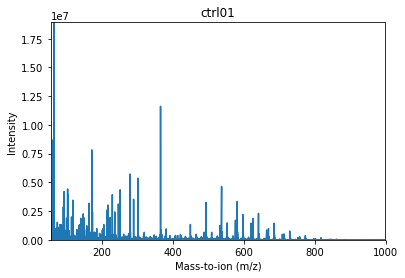

In [12]:
spectrum_list.to_list()[12].plot(scaled=False)

However, doing this for large projects is not really that feasible. Instead we can use fairly basic mean absolute deviation based outlier detection, provided by the ```dimspy``` library.

But before we can do this, we need to create a new ```SpectrumListProcessor``` object using our existing ```SpectrumList``` object:

In [13]:
processor = dimspy.SpectrumListProcessor(spectrum_list)

The ```SpectrumListProcessor``` works in similar fashion to the ```SpectrumList``` object - but contains a couple of useful methods that will greatly ease the  processing steps; as you'll soon see.

So now that we have a ```SpectrumListProcessor```, we can continue to use the provided outlier detection method to determine and remove outliers from our dataset:

/home/keo7/.virtualenvs/dimspy/local/lib/python2.7/site-packages/dimspy/SpectrumListProcessor.py:56: UserWarning:

Outlier detection removed: ctrl02,MM02,C027,ctrl01



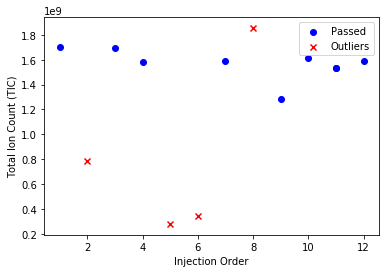

In [14]:
processor.outlier_detection(plot=True, mad_threshold=1)

In [ ]:
As you can see, the algorithm has correctly identified likely outliers. However, please note that 1 MAD

In [ ]:
processor.binning(bin_size=0.25,
                  n_jobs=n_jobs,
                  statistic="mean",
                  inplace=True)

In [ ]:
processor.center(n_jobs=n_jobs)

In [ ]:
processor.value_imputation(method="tic",
                           threshold=0.85)

In [ ]:
binned_spectrum = processor.to_spectrumlist()
b_df = binned_spectrum.flatten_to_dataframe()

import matplotlib.pyplot as plt
plt.figure()
b_df.T.plot()
plt.show()